# Kenya Floods in 2018

* Wenchang Yang (wenchang@princeton.edu)
* Department of Geosciences, Princeton University

In [1]:
!date
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['hatch.color']='g'
import xarray as xr
import pandas as pd
import datetime

import geoxarray
from geoplots import mapplot, xticks2month

Thu May 17 11:33:44 EDT 2018


## Parameters

In [2]:
# parameters
large_box = (33,42,-5,5)
small_box = (37,40,-2,4)
lons = dict(EA=slice(30,52),
            large=slice(large_box[0], large_box[1]),
            small=slice(small_box[0], small_box[1]),
           )
lats = dict(EA=slice(-10,12),
            EA_r=slice(12,-10),
            large=slice(large_box[2], large_box[3]),
            large_r=slice(large_box[3], large_box[2]),
            small=slice(small_box[2], small_box[3]),
            small_r=slice(small_box[3], small_box[2]))
kenya_box = dict(lon=slice(33,42),
            lat=slice(5,-5))
kenya_sbox = dict(lon=slice(37,40),
                 lat=slice(4,-2),
                 latb=slice(-2,4))
years_clim = slice('1981', '2011')

days_per_month = xr.DataArray([31,29,31,30,31,30,31,31,30,31,30,31], dims=['month'], coords=[range(1,13)])

pr_scale = 24*3600
prect_scale = 24*3600*1000

fignames = dict(climMA_1860='fig_climMA_1860.pdf',
                clim_1860='fig_clim_1860.pdf',
                climMA_2000='fig_climMA_2000.pdf',
                clim_diff='fig_clim_diff.pdf',
                climMA_gpcc='fig_climMA_gpcc.pdf',
                clim_gpcc='fig_clim_gpcc.pdf',
                cycle='fig_cycle.pdf', 
                cycle_sbox='fig_cycle_sbox.pdf',
                cycle_cesm='fig_cycle_cesm.pdf', 
                cycle_cesm_sbox='fig_cycle_cesm_sbox.pdf',
                accum='fig_accumulation.pdf', 
                accum_sbox='fig_accumulation_sbox.pdf',
                rmean10='fig_rollingMean10.pdf', 
                rmean10_sbox='fig_rollingMean10_sbox.pdf',
                rmean10max='fig_rollingMean10max.pdf',
                topo='fig_topo.pdf',
                clim_chirps='fig_clim_chirps.pdf')

In [3]:
def eprob(da, **kws):
    '''Exceedance Probability estimation given sample da'''
    h, b = np.histogram(da, **kws)
    csum = np.cumsum(h)
    eprob = 1- csum[:-1]/csum[-1]
    return xr.DataArray(eprob, dims='b', coords=[b[1:-1],])


## Data

In [101]:
# data das
if 'das' in locals() or 'das' in globals():
    print(das.keys())
else:
    das = dict()

dict_keys(['gpcc', 'gpcc_series', 'flor_1860', 'flor_1860_series', 'flor_2000', 'flor_2000_series', 'flor_land_mask', 'flor_zsurf', 'topo', 'chirps', 'flor_nudge_ens'])


In [39]:
# data obs
# gpcc
da = xr.open_dataarray('gpcc.nc')
da = da.sel(lon=lons['EA'], lat=lats['EA_r']) \
    .groupby('time.month')/days_per_month # mm/month -> mm/day
das['gpcc'] = da.copy()

# chirps
da = xr.open_dataarray('chirps.monthly.EA.nc').load().rename(dict(longitude='lon', latitude='lat')) \
    .groupby('time.month')/days_per_month # mm/month -> mm/day
das['chirps'] = da.copy()

# topo
das['topo'] = xr.open_dataarray('topo.nc')

In [51]:
# data FLOR
# FLOR 1860
with xr.set_options(enable_cftimeindex=True):
    da = xr.open_dataarray('PIctl_CMIP6volc.precip.EA.nc')
da = da.sel(time=slice('0051', None)).rename(dict(grid_xt='lon', grid_yt='lat')) \
    .sel(lon=lons['EA'], lat=lats['EA']) * pr_scale
das['flor_1860'] = da.copy()
    
# FLOR 2000
with xr.set_options(enable_cftimeindex=True):
    da = xr.open_dataarray('Control_2000.precip.EA.nc')
da = da.sel(time=slice('0051', None)).rename(dict(grid_xt='lon', grid_yt='lat')) \
    .sel(lon=lons['EA'], lat=lats['EA']) * pr_scale
das['flor_2000'] = da.copy()

# FLOR land_mask
das['flor_land_mask'] = xr.open_dataarray('FLOR.land_mask.nc').rename(dict(grid_xt='lon', grid_yt='lat')) \
    .sel(lon=lons['EA'], lat=lats['EA'])

# FLOR zsurf
das['flor_zsurf'] = xr.open_dataarray('FLOR.zsurf.nc').rename(dict(grid_xt='lon', grid_yt='lat')) \
    .sel(lon=lons['EA'], lat=lats['EA'])



In [102]:
# data FLOR nudgelongall
ncfiles = [f'nudgelongalle{i}_5dy_tigerx86_64.intel16_512PE.precip.EA.nc' for i in range(1,5+1)]
da_ = []
for ncfile in ncfiles:
    print(ncfile)
    with xr.set_options(enable_cftimeindex=True):
        da = xr.open_dataarray(ncfile).rename(dict(grid_xt='lon', grid_yt='lat'))
    da_.append(da)
das['flor_nudgelong_ens'] = xr.concat(da_, pd.Index(range(1,5+1), name='en')) * pr_scale

nudgelongalle1_5dy_tigerx86_64.intel16_512PE.precip.EA.nc
nudgelongalle2_5dy_tigerx86_64.intel16_512PE.precip.EA.nc
nudgelongalle3_5dy_tigerx86_64.intel16_512PE.precip.EA.nc
nudgelongalle4_5dy_tigerx86_64.intel16_512PE.precip.EA.nc
nudgelongalle5_5dy_tigerx86_64.intel16_512PE.precip.EA.nc


In [107]:
# data FLOR nudgeall
ens = range(1,3+1)
ncfiles = [f'nudgealle{i}_ersst_5dy_tigerx86_64.intel16_512PE.precip.EA.nc' for i in ens]
da_ = []
for ncfile in ncfiles:
    print(ncfile)
    da = xr.open_dataarray(ncfile).rename(dict(grid_xt='lon', grid_yt='lat'))
    da_.append(da)
das['flor_nudge_ersst_ens'] = xr.concat(da_, pd.Index(ens, name='en')) * pr_scale

nudgealle1_ersst_5dy_tigerx86_64.intel16_512PE.precip.EA.nc
nudgealle2_ersst_5dy_tigerx86_64.intel16_512PE.precip.EA.nc
nudgealle3_ersst_5dy_tigerx86_64.intel16_512PE.precip.EA.nc


In [129]:
# data CESM1.2.1
# 1850
with xr.set_options(enable_cftimeindex=True):
    da = xr.open_dataset('B1850CN_f05g16_tigercpu_680PE.prect.EA.nc').PRECT
da = da.sel(time=slice('0051', None)) * prect_scale
das['florish_1850'] = da.copy()

# 2000
with xr.set_options(enable_cftimeindex=True):
    da = xr.open_dataset('BCN_f05g16_tigercpu_680PE.prect.EA.nc').PRECT
da = da.sel(time=slice('0051', None)) * prect_scale
das['florish_2000'] = da.copy()

## Region box and topography

<IPython.core.display.Javascript object>


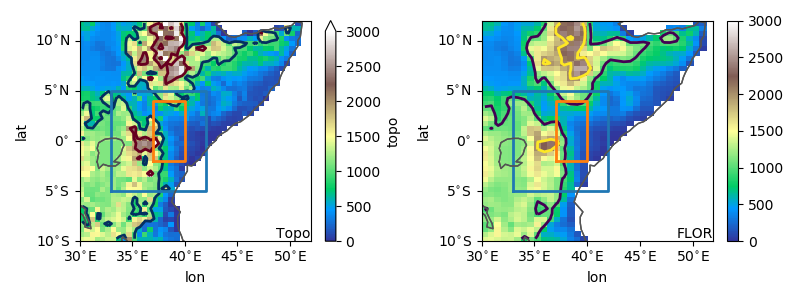

In [219]:
fig, axes = plt.subplots(1,2, figsize=(8,3))
xticks = range(30, 52+1, 5)
yticks = range(-10, 12+1, 5)

ax = axes[0]
plt.sca(ax)
da = das['topo'].sel(lon=lons['EA'], lat=lats['EA'])
da.where(da>0).plot(cmap='terrain', vmax=3000, vmin=0)
da.plot.contour(levels=[1000, 2000,])
mapplot(lonlatbox=large_box, lonlatbox_color='C0')
mapplot(lonlatbox=small_box, lonlatbox_color='C1', xticks=xticks, yticks=yticks)
plt.text(1, 0, 'Topo', ha='right', va='bottom', transform=ax.transAxes)

ax = axes[1]
plt.sca(ax)
da = das['flor_zsurf']
lmask = das['flor_land_mask']
da.where(lmask>.5).plot(cmap='terrain', vmax=3000, vmin=0)
da.where(lmask>.5).plot.contour(levels=[1000, 2000,])
mapplot(lonlatbox=large_box, lonlatbox_color='C0')
mapplot(lonlatbox=small_box, lonlatbox_color='C1', xticks=xticks, yticks=yticks)
plt.text(1, 0, 'FLOR', ha='right', va='bottom', transform=ax.transAxes)

plt.tight_layout()

plt.savefig(fignames['topo'])

## Climatology

In [62]:
# data: chirps
da = das['chirps'].sel(time=years_clim) \
    .groupby('time.month').mean('time')

<IPython.core.display.Javascript object>


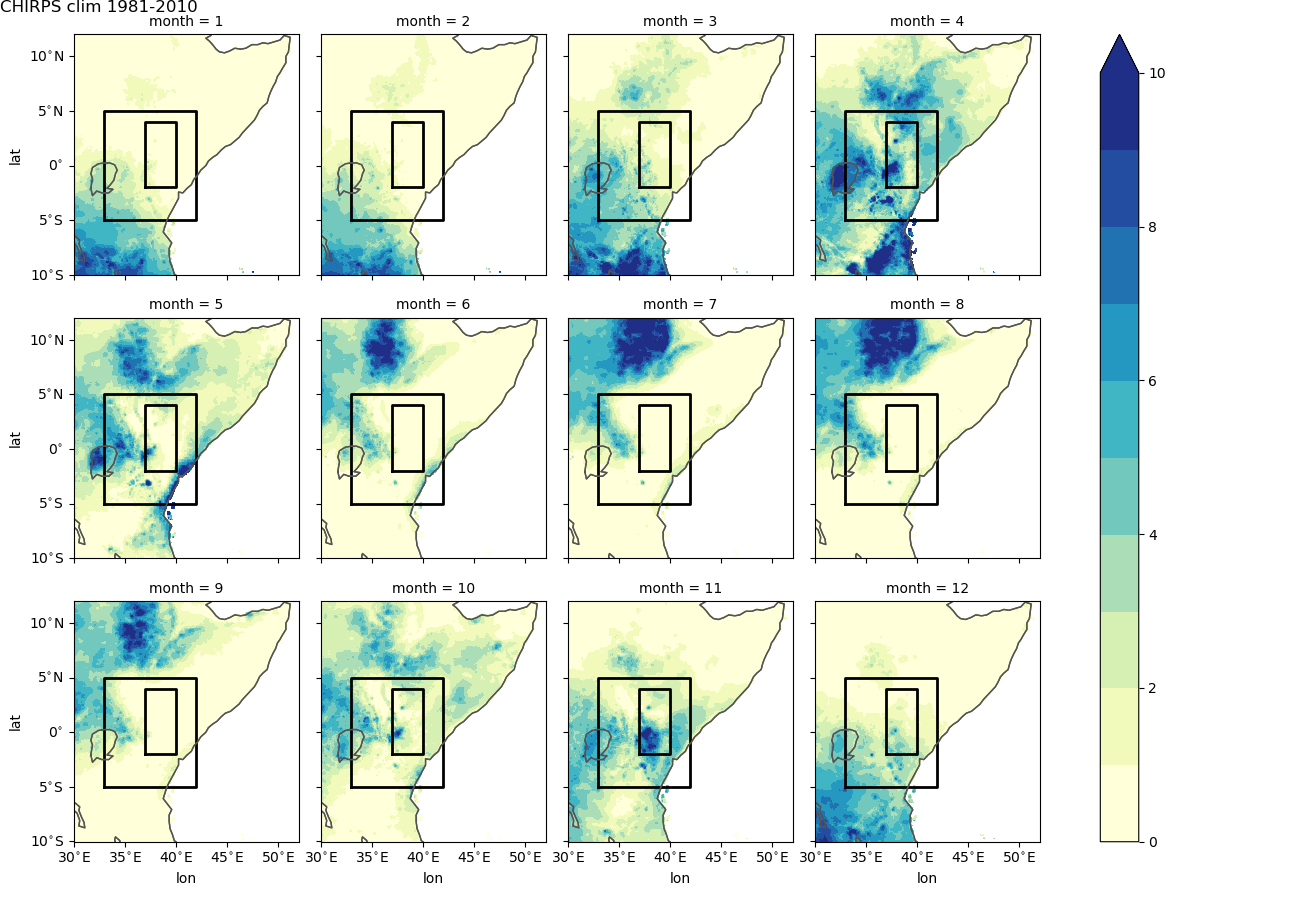

In [63]:
# plot: chirps
xticks = range(30,52+1,5)
yticks = range(-10,12+1,5)
f = da.plot.contourf(col='month', col_wrap=4, cmap='YlGnBu', levels=range(0,10+1))
for ii,ax in enumerate(f.axes.flat):
    mapplot(xticks=xticks, yticks=yticks, lonlatbox=large_box, ax=ax)
    mapplot(xticks=xticks, yticks=yticks, lonlatbox=small_box, ax=ax)
    
plt.suptitle('CHIRPS clim 1981-2010', x=0, y=1, ha='left', va='top')

plt.savefig(fignames['clim_chirps'])

### GPCC

In [54]:
# data: gpcc
da = das['gpcc'].sel(time=years_clim).groupby('time.month').mean('time')

<IPython.core.display.Javascript object>


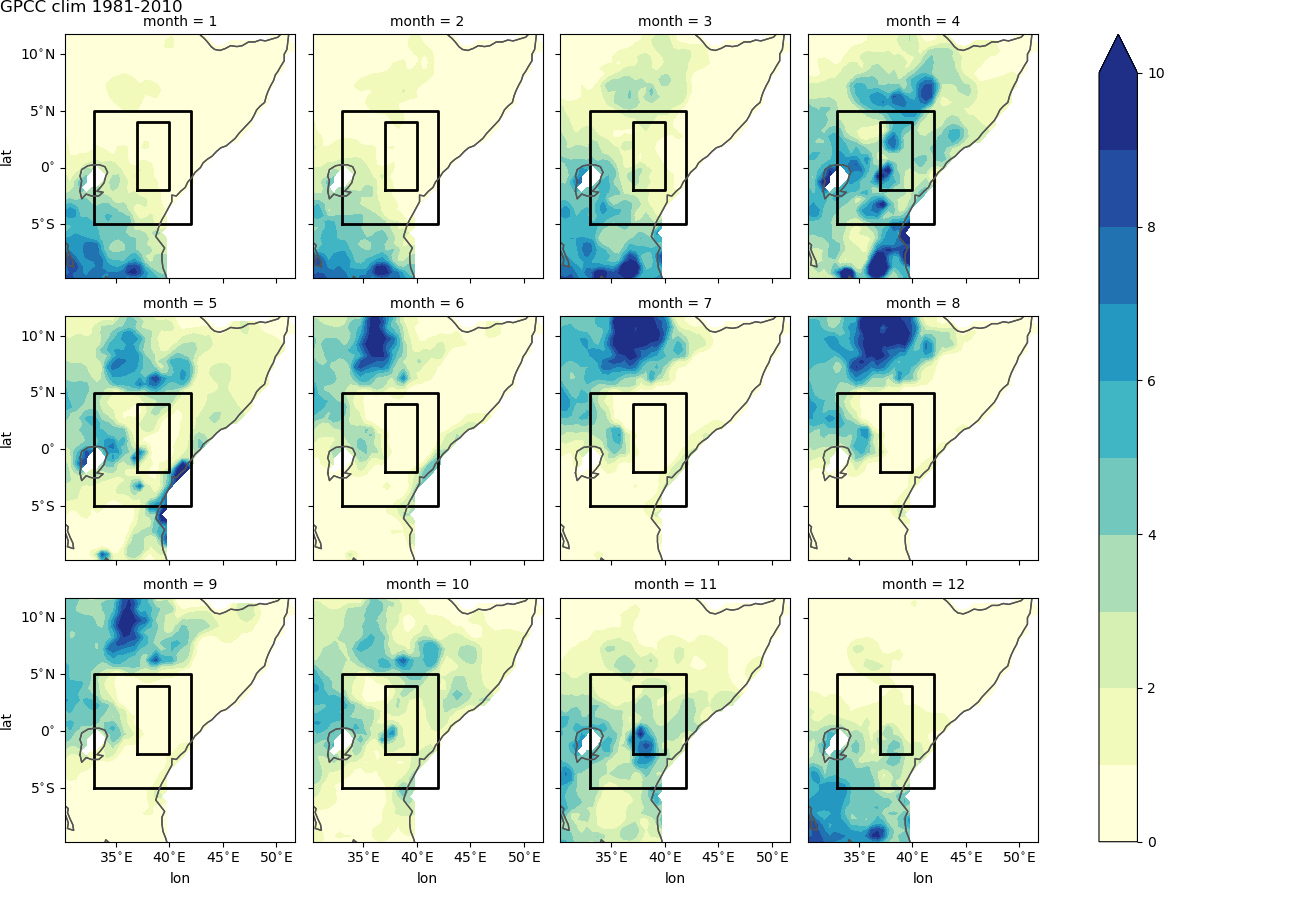

In [55]:
# plot: gpcc
xticks = range(30,52+1,5)
yticks = range(-10,12+1,5)
f = da.plot.contourf(col='month', col_wrap=4, cmap='YlGnBu', levels=range(0,10+1))
for ii,ax in enumerate(f.axes.flat):
    mapplot(xticks=xticks, yticks=yticks, lonlatbox=large_box, ax=ax)
    mapplot(xticks=xticks, yticks=yticks, lonlatbox=small_box, ax=ax)
plt.suptitle('GPCC clim 1981-2010', x=0, y=1, ha='left', va='top')

plt.savefig(fignames['clim_gpcc'])

### FLOR

In [152]:
# data: flor 1860
da = das['flor_1860'].groupby('time.month').mean('time')

<IPython.core.display.Javascript object>


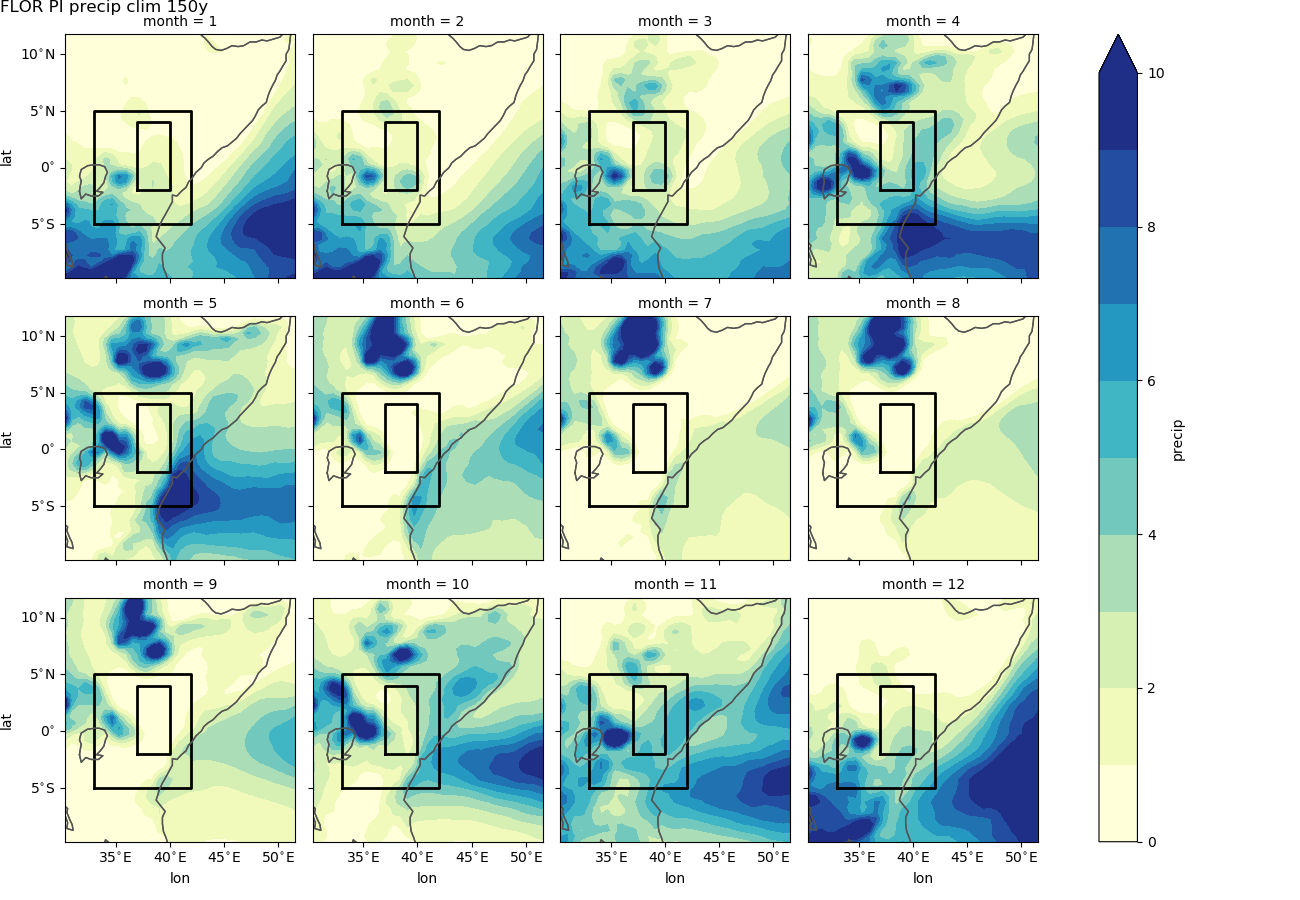

In [153]:
# plot
xticks = range(30,52+1,5)
yticks = range(-10,12+1,5)
f = da.plot.contourf(col='month', col_wrap=4, cmap='YlGnBu', levels=range(0,10+1))
for ii,ax in enumerate(f.axes.flat):
    mapplot(xticks=xticks, yticks=yticks, lonlatbox=large_box, ax=ax)
    mapplot(xticks=xticks, yticks=yticks, lonlatbox=small_box, ax=ax)
plt.suptitle('FLOR PI precip clim 150y', x=0, y=1, ha='left', va='top')

plt.savefig(fignames['clim_1860'])

In [154]:
# data
da = das['flor_2000'].groupby('time.month').mean('time') \
    - das['flor_1860'].groupby('time.month').mean('time')

<IPython.core.display.Javascript object>


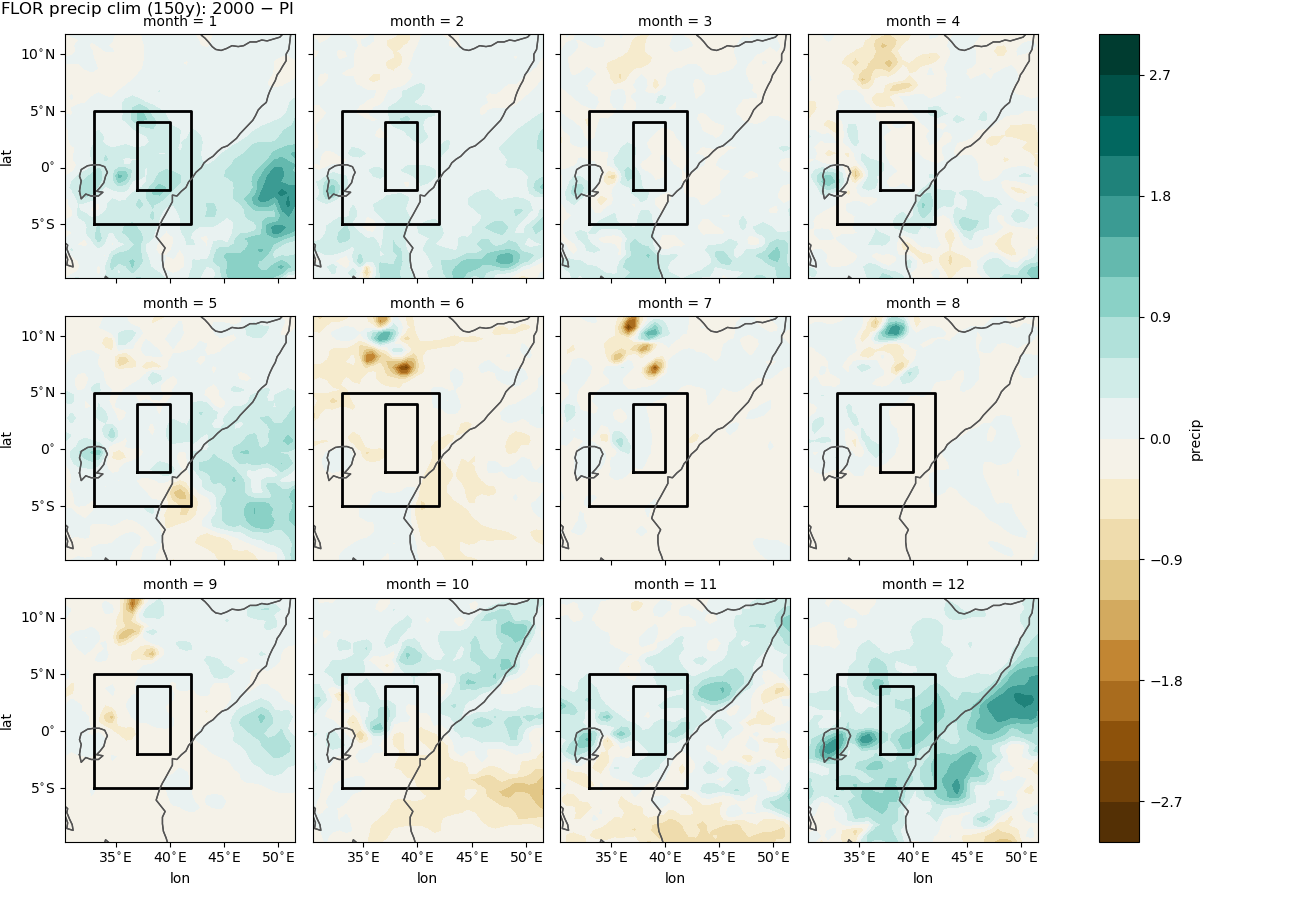

In [155]:
# plot
xticks = range(30,52+1,5)
yticks = range(-10,12+1,5)
f = da.plot.contourf(col='month', col_wrap=4, cmap='BrBG', levels=20)
for ii,ax in enumerate(f.axes.flat):
    mapplot(xticks=xticks, yticks=yticks, lonlatbox=large_box, ax=ax)
    mapplot(xticks=xticks, yticks=yticks, lonlatbox=small_box, ax=ax)
plt.suptitle('FLOR precip clim (150y): 2000 $-$ PI', x=0, y=1, ha='left', va='top')

plt.savefig(fignames['clim_diff'])

### FLORish

<IPython.core.display.Javascript object>


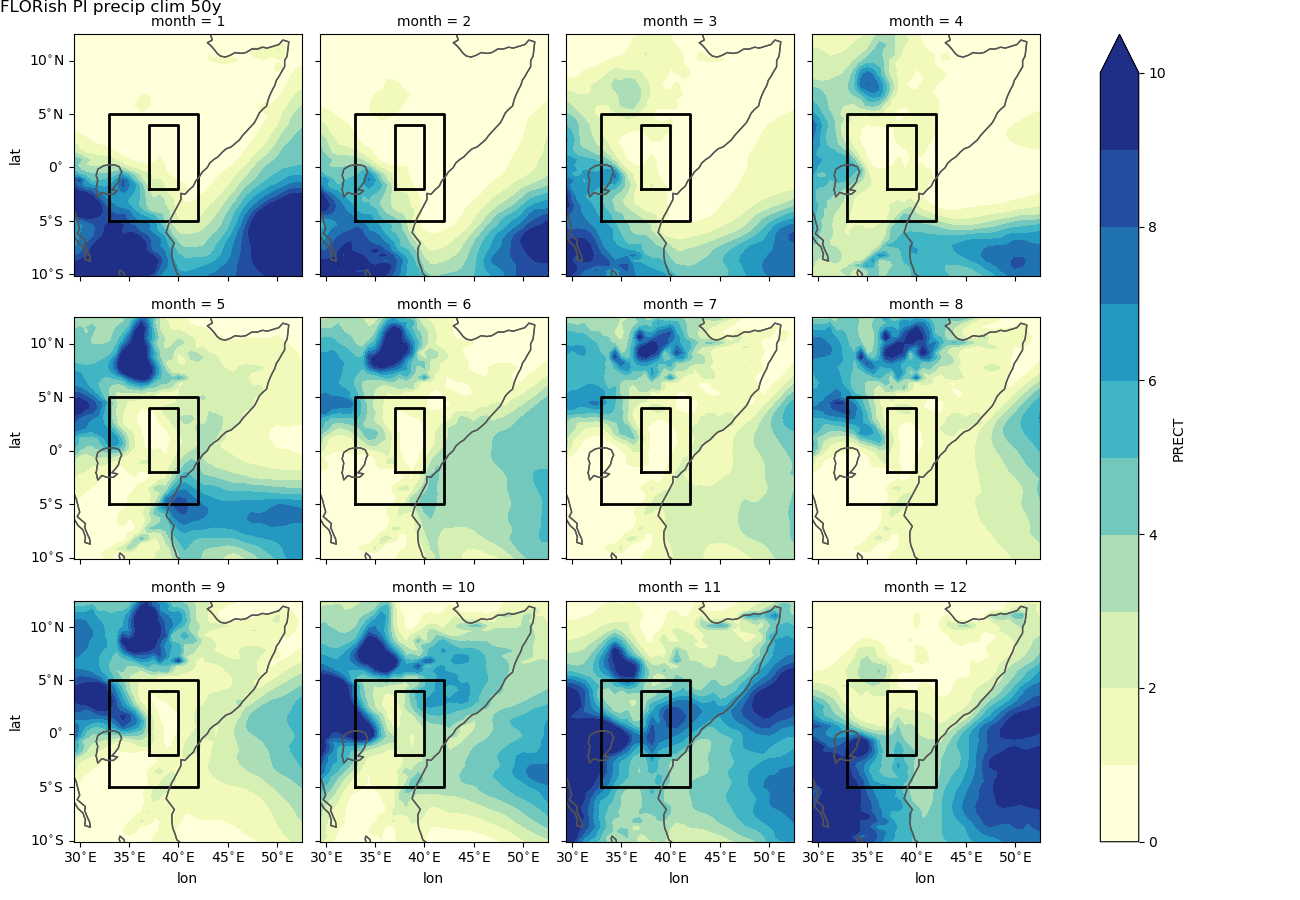

Text(0,1,'FLORish PI precip clim 50y')

In [130]:
# plot: florish 1850
da = das['florish_1850'].groupby('time.month').mean('time')
xticks = range(30,52+1,5)
yticks = range(-10,12+1,5)

f = da.plot.contourf(col='month', col_wrap=4, cmap='YlGnBu', levels=range(0,10+1))
for ii,ax in enumerate(f.axes.flat):
    mapplot(xticks=xticks, yticks=yticks, lonlatbox=large_box, ax=ax)
    mapplot(xticks=xticks, yticks=yticks, lonlatbox=small_box, ax=ax)
plt.suptitle('FLORish PI precip clim 50y', x=0, y=1, ha='left', va='top')

# plt.savefig(fignames['clim_1860'])

<IPython.core.display.Javascript object>


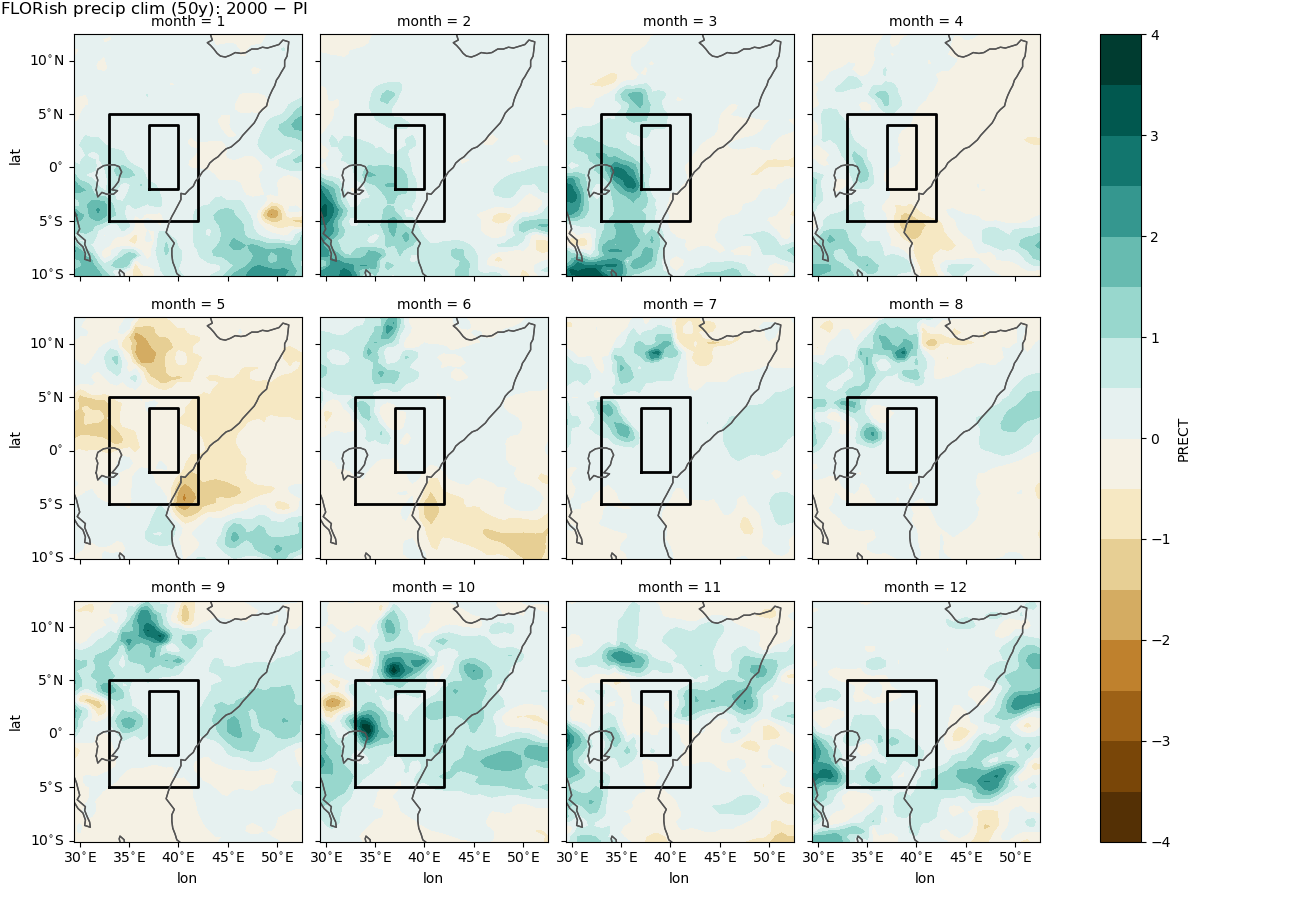

Text(0,1,'FLORish precip clim (50y): 2000 $-$ PI')

In [132]:
# plot
da = das['florish_2000'].groupby('time.month').mean('time') \
    - das['florish_1850'].groupby('time.month').mean('time')
xticks = range(30,52+1,5)
yticks = range(-10,12+1,5)

f = da.plot.contourf(col='month', col_wrap=4, cmap='BrBG', levels=20)
for ii,ax in enumerate(f.axes.flat):
    mapplot(xticks=xticks, yticks=yticks, lonlatbox=large_box, ax=ax)
    mapplot(xticks=xticks, yticks=yticks, lonlatbox=small_box, ax=ax)
plt.suptitle('FLORish precip clim (50y): 2000 $-$ PI', x=0, y=1, ha='left', va='top')

# plt.savefig(fignames['clim_diff'])

### March-Arpil

<IPython.core.display.Javascript object>


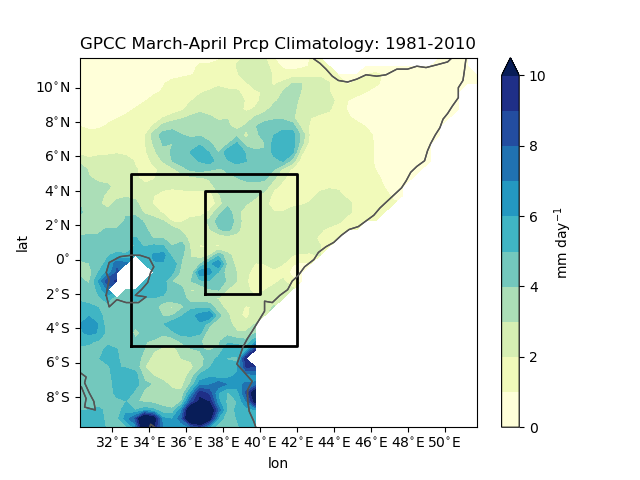

In [56]:
# plot: gpcc
da = das['gpcc'].sel(time=years_clim).pipe(lambda x: x[(x['time.month']==3) | (x['time.month']==4)]) \
    .mean('time')
da.rename('mm day$^{-1}$').plot.contourf(levels=range(0,11), cmap='YlGnBu')

mapplot(xticks=range(30, 52+1, 2), yticks=range(-10,12+1,2), lonlatbox=large_box)
mapplot(xticks=range(30, 52+1, 2), yticks=range(-10,12+1,2), lonlatbox=small_box)
plt.title('GPCC March-April Prcp Climatology: 1981-2010')

plt.savefig(fignames['climMA_gpcc'])


<IPython.core.display.Javascript object>


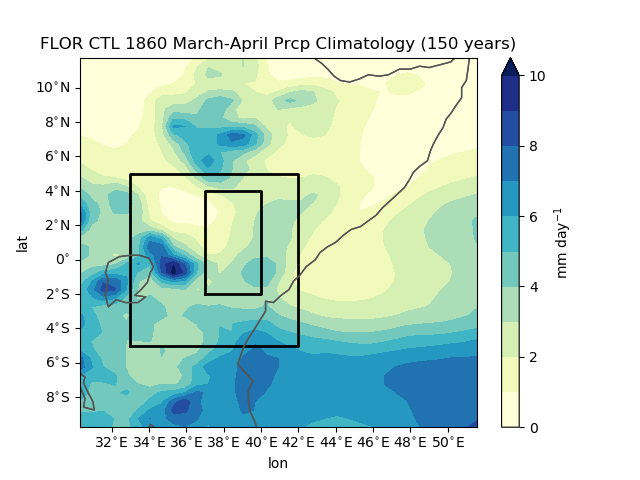

In [126]:
# plot: 1860
# da = das['flor_1860_clim']
da = das['flor_1860']
m = da['time.month']
da = da[(m==3)|(m==4)].mean('time')

da.rename('mm day$^{-1}$').plot.contourf(levels=range(0,11), cmap='YlGnBu')

mapplot(xticks=range(30, 52+1, 2), yticks=range(-10,12+1, 2), lonlatbox=large_box)
mapplot(xticks=range(30, 52+1, 2), yticks=range(-10,12+1, 2), lonlatbox=small_box)
plt.title('FLOR CTL 1860 March-April Prcp Climatology (150 years)')

plt.savefig(fignames['climMA_1860'])
# da.assign_attrs(units='mm/day', long_name='precipitation').to_netcdf('FLOR_1860_prcp_climMA.nc')

## Seasonal cycle

<IPython.core.display.Javascript object>


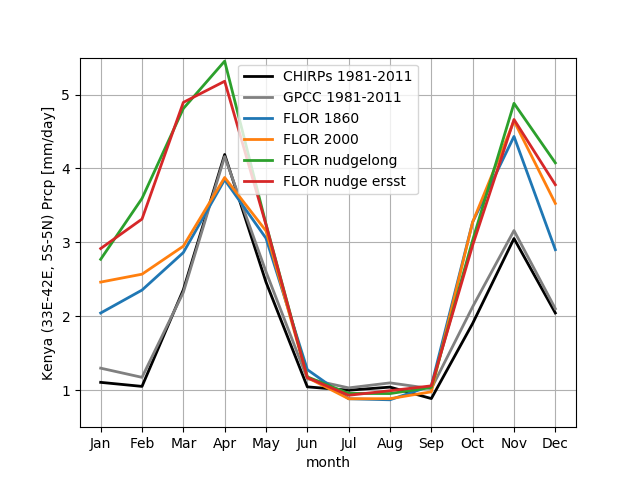

In [106]:
# plot: seasonal cycle
lmask = das['flor_land_mask'].sel(lon=lons['large'], lat=lats['large'])

das['chirps'].sel(lon=lons['large'], lat=lats['large'], time=years_clim).geo.fldmean() \
    .groupby('time.month').mean('time') \
    .plot(label='CHIRPs 1981-2011', color='k')
das['gpcc'].sel(lon=lons['large'], lat=lats['large_r'], time=years_clim).geo.fldmean() \
    .groupby('time.month').mean('time') \
    .plot(label='GPCC 1981-2011', color='gray')
das['flor_1860'].sel(lon=lons['large'], lat=lats['large']) \
    .where(lmask>.5).geo.fldmean() \
    .groupby('time.month').mean('time') \
    .plot(label='FLOR 1860')
das['flor_2000'].sel(lon=lons['large'], lat=lats['large']) \
    .where(lmask>.5).geo.fldmean() \
    .groupby('time.month').mean('time') \
    .plot(label='FLOR 2000')
das['flor_nudgelong_ens'].sel(lon=lons['large'], lat=lats['large'], time=years_clim) \
    .where(lmask>.5).geo.fldmean() \
    .groupby('time.month').mean('time') \
    .mean('en') \
    .plot(label='FLOR nudgelong')
das['flor_nudge_ens'].sel(lon=lons['large'], lat=lats['large'], time=years_clim) \
    .where(lmask>.5).geo.fldmean() \
    .groupby('time.month').mean('time') \
    .mean('en') \
    .plot(label='FLOR nudge ersst')

xticks2month(range(1,13))
plt.legend(frameon=True, loc='upper center')
plt.grid(True)
plt.ylabel(f'Kenya ({large_box[0]}E-{large_box[1]}E, {-large_box[2]}S-{large_box[3]}N) Prcp [mm/day]')
plt.ylim(.5,5.5)

plt.savefig(fignames['cycle'])

### small region box

<IPython.core.display.Javascript object>


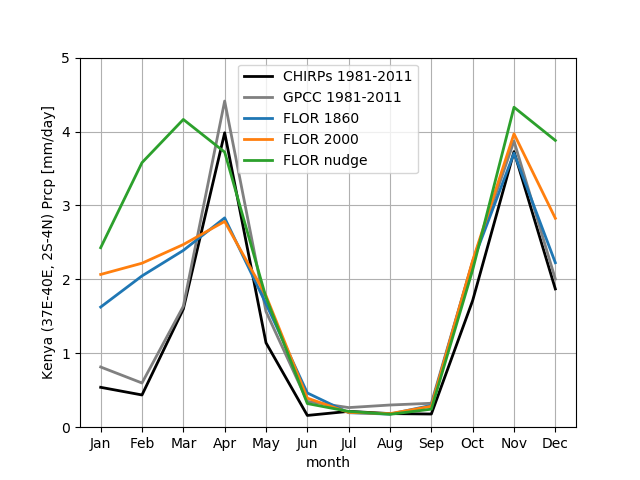

In [105]:
# plot: seasonal cycle
lmask = das['flor_land_mask'].sel(lon=lons['small'], lat=lats['small'])

das['chirps'].sel(lon=lons['small'], lat=lats['small'], time=years_clim).geo.fldmean() \
    .groupby('time.month').mean('time') \
    .plot(label='CHIRPs 1981-2011', color='k')
das['gpcc'].sel(lon=lons['small'], lat=lats['small_r'], time=years_clim).geo.fldmean() \
    .groupby('time.month').mean('time') \
    .plot(label='GPCC 1981-2011', color='gray')
das['flor_1860'].sel(lon=lons['small'], lat=lats['small']) \
    .where(lmask>.5).geo.fldmean() \
    .groupby('time.month').mean('time') \
    .plot(label='FLOR 1860')
das['flor_2000'].sel(lon=lons['small'], lat=lats['small']) \
    .where(lmask>.5).geo.fldmean() \
    .groupby('time.month').mean('time') \
    .plot(label='FLOR 2000')
das['flor_nudgelong_ens'].sel(lon=lons['small'], lat=lats['small'], time=years_clim) \
    .where(lmask>.5).geo.fldmean() \
    .groupby('time.month').mean('time') \
    .mean('en') \
    .plot(label='FLOR nudge')

xticks2month(range(1,13))
plt.legend(frameon=True)
plt.grid(True)
plt.ylabel(f'Kenya ({small_box[0]}E-{small_box[1]}E, {-small_box[2]}S-{small_box[3]}N) Prcp [mm/day]')
plt.ylim(0,5)

plt.savefig(fignames['cycle_sbox'])

### CESM1.2.1

<IPython.core.display.Javascript object>


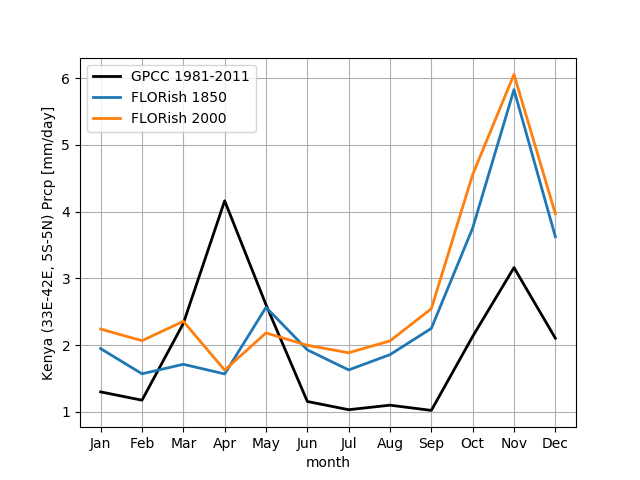

In [247]:
# plot: seasonal cycle
das['gpcc'].groupby('time.month').mean('time') \
    .plot(label='GPCC 1981-2011', color='k')
das['florish_1850'].groupby('time.month').mean('time').plot(label='FLORish 1850')
das['florish_2000'].groupby('time.month').mean('time').plot(label='FLORish 2000')

xticks2month(range(1,13))
plt.legend(frameon=True)
plt.grid(True)
plt.ylabel('Kenya (33E-42E, 5S-5N) Prcp [mm/day]')

plt.savefig(fignames['cycle_cesm'])

### CESM1.2.1 small region box

<IPython.core.display.Javascript object>


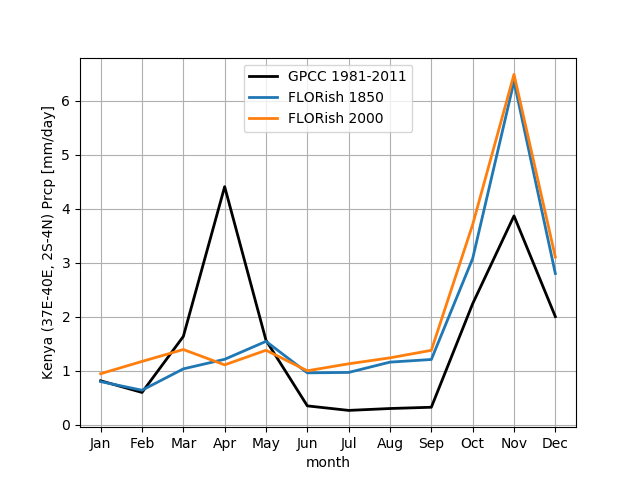

In [248]:
# plot: seasonal cycle

da = das['gpcc_s'].groupby('time.month')
damean = da.mean('time')
da.mean('time').plot(label='GPCC 1981-2011', color='k')
# plt.fill_between(damean.month, da.reduce(np.percentile, q=10), da.reduce(np.percentile, q=90), alpha=.5, color='k')

da = das['florish_1850_s'].groupby('time.month')
damean = da.mean('time')
da.mean('time').plot(label='FLORish 1850')
# plt.fill_between(damean.month, da.reduce(np.percentile, q=10), da.reduce(np.percentile, q=90), alpha=.5)

da = das['florish_2000_s'].groupby('time.month')
damean = da.mean('time')
damean.plot(label='FLORish 2000')
# plt.fill_between(damean.month, da.reduce(np.percentile, q=10), da.reduce(np.percentile, q=90), alpha=.5)


xticks2month(range(1,13))
plt.legend(frameon=True, loc='upper center')
plt.grid(True)
plt.ylabel('Kenya (37E-40E, 2S-4N) Prcp [mm/day]')

plt.savefig(fignames['cycle_cesm_sbox'])

## Series

<IPython.core.display.Javascript object>


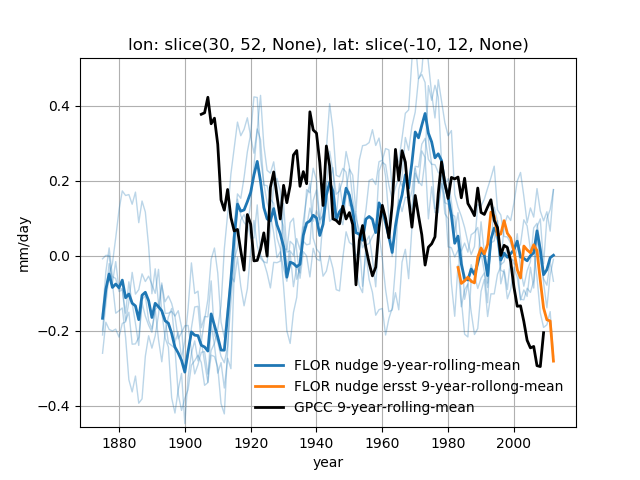

Text(0.5,1,'lon: slice(30, 52, None), lat: slice(-10, 12, None)')

In [122]:
# plot EA box
lmask = das['flor_land_mask']
da = das['flor_nudgelong_ens']
m = da['time.month']
months = da.time[(m>=3) & (m<=5)]
da = da.sel(time=months).groupby('time.year').mean('time') \
    .sel(lon=lons['EA'], lat=lats['EA']).where(lmask>.5).geo.fldmean()  \
    .pipe(lambda x: x - x.sel(year=slice(1981,2010)).mean(['en', 'year']))
for i in range(1,5+1):
    da.sel(en=i).rolling(year=9, center=True).mean().plot(color='C0', lw=1, alpha=.3)
# da.mean('en').plot(label='FLOR nudge ensemble-mean MAM precip')
da.mean('en').rolling(year=9, center=True).mean().plot(label='FLOR nudge 9-year-rolling-mean')

da = das['flor_nudge_ersst_ens']
m = da['time.month']
months = da.time[(m>=3) & (m<=5)]
da = da.sel(time=months).groupby('time.year').mean('time') \
    .sel(lon=lons['EA'], lat=lats['EA']).where(lmask>.5).geo.fldmean()  \
    .pipe(lambda x: x - x.sel(year=slice(1981,2010)).mean(['en', 'year'])) \
    .mean('en') \
    .rolling(year=9, center=True).mean().plot(label='FLOR nudge ersst 9-year-rollong-mean')

das['gpcc'].pipe(lambda x: x[(x['time.month']>=3) & (x['time.month']<=5)]).groupby('time.year').mean('time') \
    .sel(lon=lons['EA'], lat=lats['EA_r']).geo.fldmean() \
    .pipe(lambda x: x - x.sel(year=slice(1981,2010)).mean()) \
    .rolling(year=9, center=True).mean() \
    .plot(color='k', label='GPCC 9-year-rolling-mean')

plt.grid(True)
plt.ylabel('mm/day')
plt.legend()
plt.title(f"lon: {lons['EA']}, lat: {lats['EA']}")

### large region box

<IPython.core.display.Javascript object>


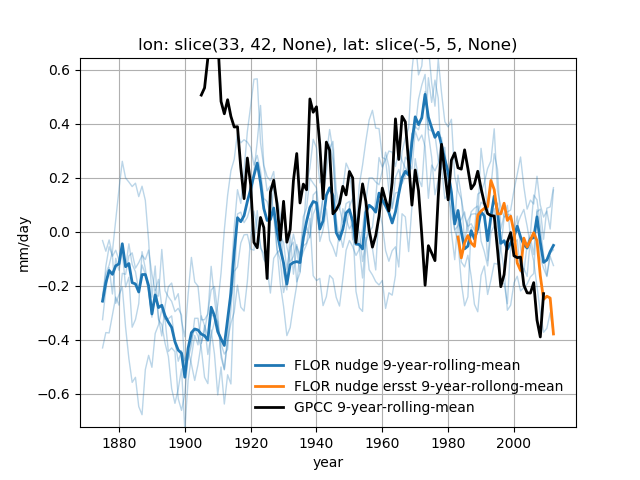

Text(0.5,1,'lon: slice(33, 42, None), lat: slice(-5, 5, None)')

In [123]:
# plot large box
lmask = das['flor_land_mask']
m = daens['time.month']
months = daens.time[(m>=3) & (m<=5)]
da = das['flor_nudgelong_ens'].sel(time=months).groupby('time.year').mean('time') \
    .sel(lon=lons['large'], lat=lats['large']).where(lmask>.5).geo.fldmean()  \
    .pipe(lambda x: x - x.sel(year=slice(1981,2010)).mean(['en', 'year']))
for i in range(1,5+1):
    da.sel(en=i).rolling(year=9, center=True).mean().plot(color='C0', lw=1, alpha=.3)
# da.mean('en').plot(label='FLOR nudge ensemble-mean MAM precip')
da.mean('en').rolling(year=9, center=True).mean().plot(label='FLOR nudge 9-year-rolling-mean')

da = das['flor_nudge_ersst_ens']
m = da['time.month']
months = da.time[(m>=3) & (m<=5)]
da = da.sel(time=months).groupby('time.year').mean('time') \
    .sel(lon=lons['large'], lat=lats['large']).where(lmask>.5).geo.fldmean()  \
    .pipe(lambda x: x - x.sel(year=slice(1981,2010)).mean(['en', 'year'])) \
    .mean('en') \
    .rolling(year=9, center=True).mean().plot(label='FLOR nudge ersst 9-year-rollong-mean')

das['gpcc'].pipe(lambda x: x[(x['time.month']>=3) & (x['time.month']<=5)]).groupby('time.year').mean('time') \
    .sel(lon=lons['large'], lat=lats['large_r']).geo.fldmean() \
    .pipe(lambda x: x - x.sel(year=slice(1981,2010)).mean()) \
    .rolling(year=9, center=True).mean() \
    .plot(color='k', label='GPCC 9-year-rolling-mean')

plt.grid(True)
plt.ylabel('mm/day')
plt.legend()
plt.title(f"lon: {lons['large']}, lat: {lats['large']}")

### small region box

<IPython.core.display.Javascript object>


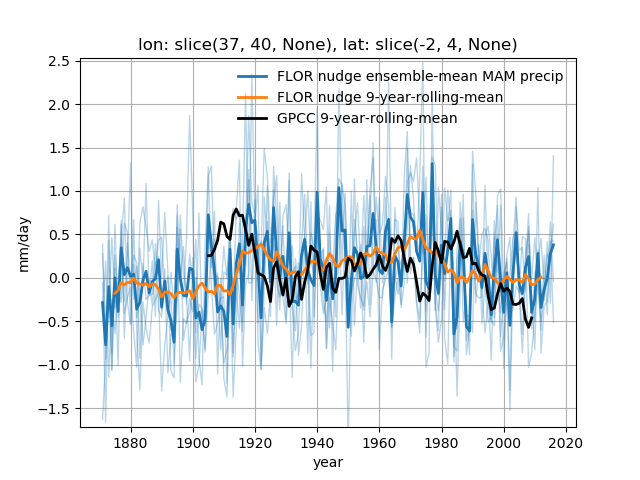

Text(0.5,1,'lon: slice(37, 40, None), lat: slice(-2, 4, None)')

In [95]:
# plot large box
lmask = das['flor_land_mask']
m = daens['time.month']
months = daens.time[(m>=3) & (m<=5)]
da = das['flor_nudge_ens'].sel(time=months).groupby('time.year').mean('time') \
    .sel(lon=lons['small'], lat=lats['small']).where(lmask>.5).geo.fldmean()  \
    .pipe(lambda x: x - x.sel(year=slice(1981,2010)).mean(['en', 'year']))
for i in range(1,5+1):
    da.sel(en=i).plot(color='C0', lw=1, alpha=.3)
da.mean('en').plot(label='FLOR nudge ensemble-mean MAM precip')
da.mean('en').rolling(year=9, center=True).mean().plot(label='FLOR nudge 9-year-rolling-mean')

das['gpcc'].pipe(lambda x: x[(x['time.month']>=3) & (x['time.month']<=5)]).groupby('time.year').mean('time') \
    .sel(lon=lons['small'], lat=lats['small_r']).geo.fldmean() \
    .pipe(lambda x: x - x.sel(year=slice(1981,2010)).mean()) \
    .rolling(year=9, center=True).mean() \
    .plot(color='k', label='GPCC 9-year-rolling-mean')

plt.grid(True)
plt.ylabel('mm/day')
plt.legend()
plt.title(f"lon: {lons['small']}, lat: {lats['small']}")

In [91]:
print(lons['large'])

slice(33, 42, None)


## Accumulation 

<IPython.core.display.Javascript object>


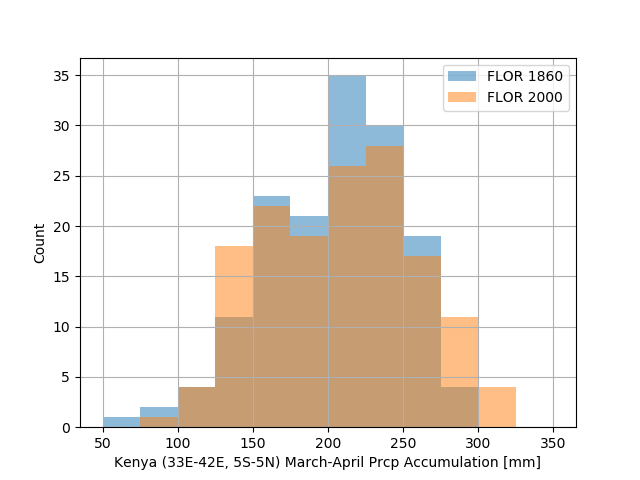

In [142]:
# plot
lmask = das['flor_land_mask'].sel(lon=lons['large'], lat=lats['large'])
bins = range(50,350+1,25)
da = das['flor_1860'].sel(lon=lons['large'], lat=lats['large']).where(lmask>.5).geo.fldmean()
da = da[(da['time.month']==3) | (da['time.month']==4)]
da.resample(time='AS').sum().plot.hist(label='FLOR 1860', bins=bins, alpha=.5)

da = das['flor_2000'].sel(lon=lons['large'], lat=lats['large']).where(lmask>.5).geo.fldmean()
da = da[(da['time.month']==3) | (da['time.month']==4)]
da.resample(time='AS').sum().plot.hist(label='FLOR 2000', bins=bins, alpha=.5)

plt.grid(True)
plt.legend(frameon=True)
plt.xlabel(f'Kenya ({large_box[0]}E-{large_box[1]}E, {-large_box[2]}S-{large_box[3]}N) March-April Prcp Accumulation [mm]')
plt.savefig(fignames['accum'])

### small region box

<IPython.core.display.Javascript object>


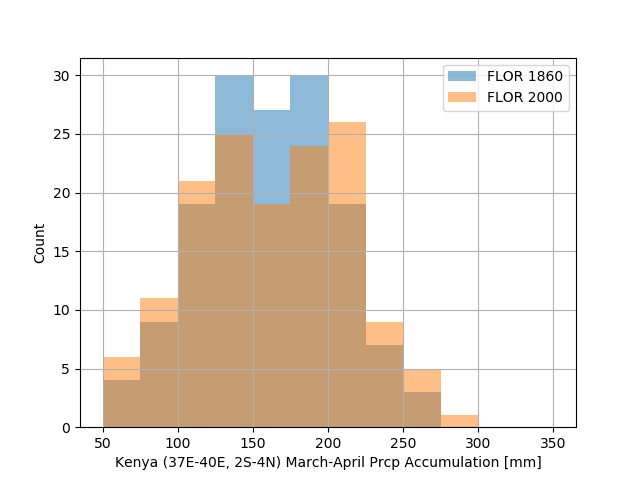

In [143]:
# plot
lmask = das['flor_land_mask'].sel(lon=lons['small'], lat=lats['small'])
bins = range(50,350+1,25)
da = das['flor_1860'].sel(lon=lons['small'], lat=lats['small']).where(lmask>.5).geo.fldmean()
da = da[(da['time.month']==3) | (da['time.month']==4)]
da.resample(time='AS').sum().plot.hist(label='FLOR 1860', bins=bins, alpha=.5)

da = das['flor_2000'].sel(lon=lons['small'], lat=lats['small']).where(lmask>.5).geo.fldmean()
da = da[(da['time.month']==3) | (da['time.month']==4)]
da.resample(time='AS').sum().plot.hist(label='FLOR 2000', bins=bins, alpha=.5)

plt.grid(True)
plt.legend(frameon=True)
plt.xlabel(f'Kenya ({small_box[0]}E-{small_box[1]}E, {-small_box[2]}S-{small_box[3]}N) March-April Prcp Accumulation [mm]')
plt.savefig(fignames['accum_sbox'])

## 10-day mean

<IPython.core.display.Javascript object>


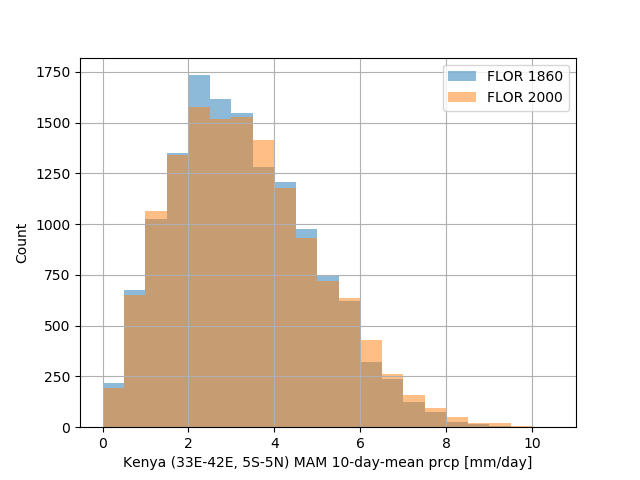

In [166]:
# plot
lmask = das['flor_land_mask'].sel(lon=lons['large'], lat=lats['large'])
alpha = .5
bins = np.arange(0,11,.5)

da = das['flor_1860'].sel(lon=lons['large'], lat=lats['large']).where(lmask>.5).geo.fldmean() \
    .rolling(time=10).mean() \
    .pipe(lambda x: x[(x['time.month']>=3) & (x['time.month']<=5)])
da.plot.hist(alpha=alpha, label='FLOR 1860', bins=bins)

da = das['flor_2000'].sel(lon=lons['large'], lat=lats['large']).where(lmask>.5).geo.fldmean() \
    .rolling(time=10).mean() \
    .pipe(lambda x: x[(x['time.month']>=3) & (x['time.month']<=5)])
da.plot.hist(alpha=alpha, label='FLOR 2000', bins=bins)

# plt.axvline(7, color='k', ls='--')

plt.grid(True)
plt.legend(frameon=True)
plt.xlabel(f'Kenya ({large_box[0]}E-{large_box[1]}E, {-large_box[2]}S-{large_box[3]}N) MAM 10-day-mean prcp [mm/day]')
plt.savefig(fignames['rmean10'])

### small region box

<IPython.core.display.Javascript object>


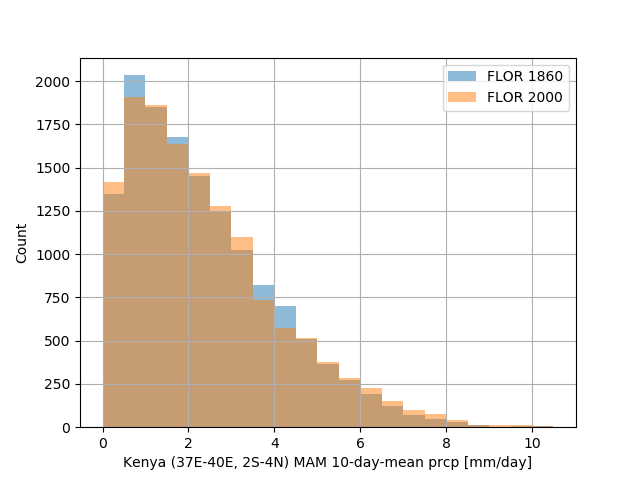

In [167]:
# plot
lmask = das['flor_land_mask'].sel(lon=lons['small'], lat=lats['small'])
alpha = .5
bins = np.arange(0,11,.5)

da = das['flor_1860'].sel(lon=lons['small'], lat=lats['small']).where(lmask>.5).geo.fldmean() \
    .rolling(time=10).mean() \
    .pipe(lambda x: x[(x['time.month']>=3) & (x['time.month']<=5)])
da.plot.hist(alpha=alpha, label='FLOR 1860', bins=bins)

da = das['flor_2000'].sel(lon=lons['small'], lat=lats['small']).where(lmask>.5).geo.fldmean() \
    .rolling(time=10).mean() \
    .pipe(lambda x: x[(x['time.month']>=3) & (x['time.month']<=5)])
da.plot.hist(alpha=alpha, label='FLOR 2000', bins=bins)

# plt.axvline(7, color='k', ls='--')

plt.grid(True)
plt.legend(frameon=True)
plt.xlabel(f'Kenya ({small_box[0]}E-{small_box[1]}E, {-small_box[2]}S-{small_box[3]}N) MAM 10-day-mean prcp [mm/day]')
plt.savefig(fignames['rmean10_sbox'])

## 10-day mean max

<IPython.core.display.Javascript object>


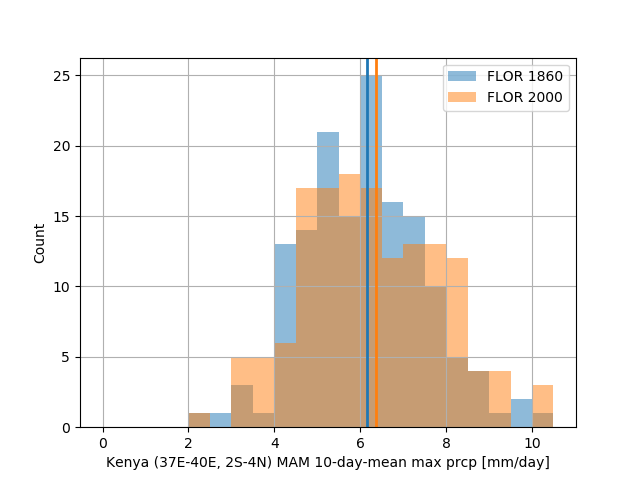

In [165]:
# plot
lmask = das['flor_land_mask'].sel(lon=lons['small'], lat=lats['small'])
alpha = .5
bins = np.arange(0,11,.5)

da = das['flor_1860'].sel(lon=lons['small'], lat=lats['small']).where(lmask>.5).geo.fldmean() \
    .rolling(time=10).mean() \
    .pipe(lambda x: x[(x['time.month']>=3) & (x['time.month']<=5)]) \
    .resample(time='AS').max('time')
da.plot.hist(alpha=alpha, label='FLOR 1860', bins=bins)
plt.axvline(da.mean(), color='C0')

da = das['flor_2000'].sel(lon=lons['small'], lat=lats['small']).where(lmask>.5).geo.fldmean() \
    .rolling(time=10).mean() \
    .pipe(lambda x: x[(x['time.month']>=3) & (x['time.month']<=5)]) \
    .resample(time='AS').max('time')
da.plot.hist(alpha=alpha, label='FLOR 2000', bins=bins)
plt.axvline(da.mean(), color='C1')


plt.grid(True)
plt.legend(frameon=True)
plt.xlabel(f'Kenya ({small_box[0]}E-{small_box[1]}E, {-small_box[2]}S-{small_box[3]}N) MAM 10-day-mean max prcp [mm/day]')
plt.savefig(fignames['rmean10max'])

## Test

<xarray.DataArray (year: 150)>
array([  7.852582,   5.994334,   6.182166,   7.123322,   7.70577 ,   2.215512,
         4.666829,   4.624475,   7.323366,   5.667046,   7.551139,   6.1428  ,
         8.370566,   5.387732,   4.856143,   4.256571,   6.513383,   5.832238,
         7.10669 ,   5.178564,   7.306029,   3.437582,   6.092869,   7.946659,
         5.344721,   3.502966,   6.02475 ,   4.656159,   4.88428 ,   7.341108,
         3.463592,   5.879177,   7.648505,   4.959157,   6.115832,   5.448234,
         5.547099,   6.353749,   8.87645 ,   7.087645,   4.393295,   6.358448,
         4.595623,   5.175792,   4.856151,   7.281311,   4.329596,   5.073731,
         6.186392,   5.448354,   6.635542,   8.5264  ,   6.868584,   8.611661,
         4.352242,   4.341191,   5.257438,   8.421368,   4.944497,   5.428818,
         5.148984,   5.658387,   7.121816,   6.351389,   4.383651,   3.071221,
         8.630564,   6.001616,   7.046478,   4.235575,   7.740114,   4.971564,
         6.419853,   

<IPython.core.display.Javascript object>


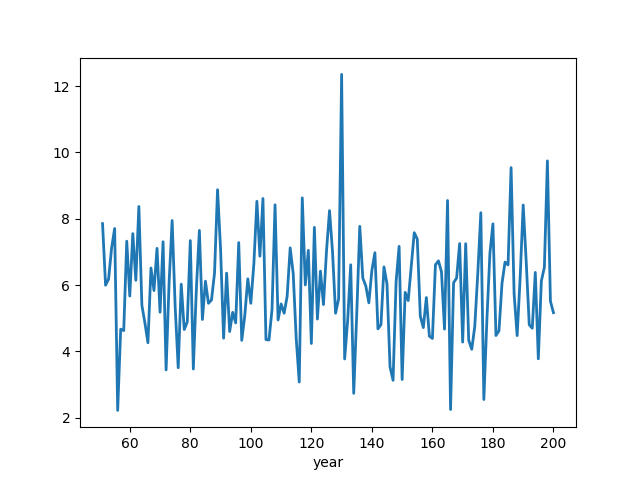

In [151]:
da = das['flor_1860']
da = da.sel(lon=lons['small'], lat=lats['small']).geo.fldmean() \
    .rolling(time=10, center=True).mean() \
    .pipe(lambda x: x[(x.time.dt.month>=3) & (x.time.dt.month<=4)]) \
    .groupby('time.year').max()
print(da)
da.plot()

In [153]:
import skextremes as ske

In [204]:
model = ske.models.classic.GEV(da.values, fit_method='mle', ci=0.05, ci_method='delta', return_periods=[100,130])

//home/wenchang/wython/skextremes/models/classic.py:527: RuntimeWarning: divide by zero encountered in log
  sT = -_np.log(1.-self.frec/T)
//home/wenchang/wython/skextremes/models/classic.py:527: RuntimeWarning: invalid value encountered in log
  sT = -_np.log(1.-self.frec/T)
//home/wenchang/wython/skextremes/models/classic.py:502: RuntimeWarning: invalid value encountered in log
  (1. + 1. / c) * _np.sum(_np.log(expr)) +
//home/wenchang/wython/skextremes/models/classic.py:503: RuntimeWarning: invalid value encountered in power
  _np.sum(expr ** (-1. / c)))
/tigress/wenchang/miniconda3/lib/python3.6/site-packages/numdifftools/extrapolation.py:443: RuntimeWarning: invalid value encountered in less_equal
  converged = err <= tol
/tigress/wenchang/miniconda3/lib/python3.6/site-packages/numdifftools/limits.py:150: RuntimeWarning: invalid value encountered in less
  outliers = (((abs(der) < (a_median / trim_fact)) +
/tigress/wenchang/miniconda3/lib/python3.6/site-packages/numdifftools/limit

In [208]:
print(model.params)
print(model.return_values)
print(model.return_periods)

OrderedDict([('shape', 0.15088231480675668), ('location', 5.2575751226739396), ('scale', 1.4916581227297798)])
[ 10.20530759  10.39781736]
[100 130]


<IPython.core.display.Javascript object>


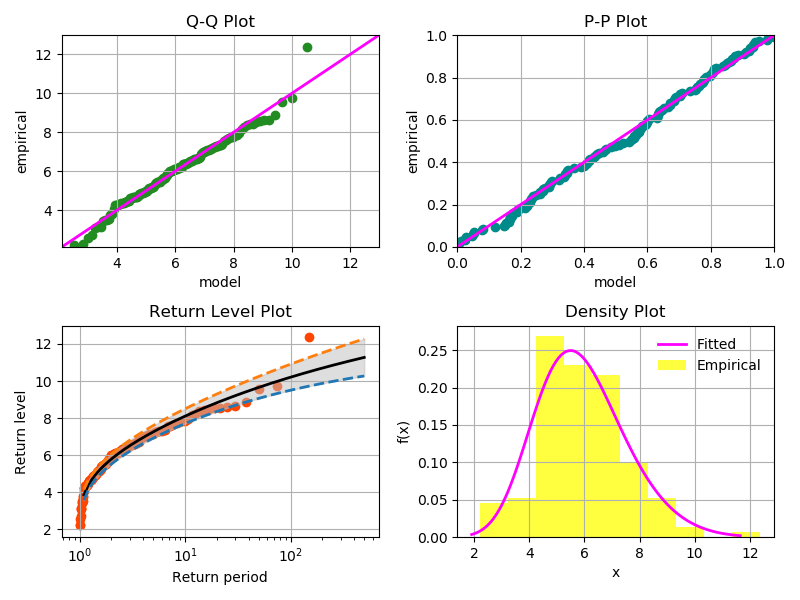

/tigress/wenchang/miniconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


(<Figure size 800x600 with 4 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x2aeee6545b70>)

In [163]:
model.plot_summary()